In [31]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import geoplot

In [32]:
df_enc = pd.read_csv('data\encounter-events.csv')
df_loit = pd.read_csv('data\loitering-events.csv')
df_ves = pd.read_csv('data/transshipment-vessels.csv')

# Data Transformation

## Preprocessing

### Encounter Dataset

This code:

* removes all entries with duplicate values over all features
* removes outliers in duration_hr column
* transforms timestamps into floats and creates new time features as datetime objects
* adds a support feature to the dataset

In [33]:
df_enc_mod = df_enc.copy()

df_enc_mod = df_enc_mod.loc[df_enc_mod['duration_hr'] <= 65]  # remove outliers detected in the EDA file

df_enc_mod.drop_duplicates(inplace = True)  # remove duplicates

df_enc_mod = df_enc_mod[df_enc_mod['fishing_vessel_mmsi'].astype(str).str.len() == 9]
# remove all instances with wrong fishing_vessel_mmsi format

print('{} encounterings left in the dataset'.format(df_enc_mod.shape[0]))

11458 encounterings left in the dataset


In [34]:
df_enc_mod['start_time'] = pd.to_datetime(df_enc['start_time'])  # parse time objects
df_enc_mod['end_time'] = pd.to_datetime(df_enc['end_time'])

df_enc_mod['starting_timestamp'] = df_enc_mod['start_time'].apply(lambda x: x.timestamp()) # Changing format of timestamps from object to float
df_enc_mod['ending_timestamp'] = df_enc_mod['end_time'].apply(lambda x: x.timestamp())

# df_enc_mod.head()

In [35]:
df_enc_mod['from_encounter'] = 1  # support variable need later after merging

In [36]:
#df_enc_mod.info()

### Loitering Dataset

This code:

* removes all entries with duplicate values over all features
* remove outliers in total_even_duration column
* Creates new feature and removes redundant features
* transforms timestamps into floats and creates new time features as datetime objects
* adds a support feature to the dataset
* both transforms and renames features to those in the encounter dataset

In [37]:
df_loit_mod =  df_loit.copy()
print(df_loit_mod.head())
df_loit_mod = df_loit_mod.loc[df_loit_mod['total_event_duration'] <= 200]  # remove outliers detected in the EDA file

df_loit_mod.drop_duplicates(inplace = True)  # dropping duplicates

print('{} loitering events left in the dataset'.format(df_loit_mod.shape[0]))

   transshipment_mmsi  starting_latitude  starting_longitude  ending_latitude  \
0           256064000          12.793800          -69.503235        12.727950   
1           256064000          25.405013          -56.302800        25.393350   
2           256064000          10.693413          -78.512800        10.484500   
3           256064000          11.858933          -75.553383        12.007627   
4           256064000          45.938747          -23.796960        45.976960   

   ending_longitude    starting_timestamp      ending_timestamp  \
0        -69.739120  2017-09-06T02:11:32Z  2017-09-06T15:44:15Z   
1        -56.488250  2017-07-22T13:19:49Z  2017-07-22T23:59:17Z   
2        -78.884300  2017-11-29T14:48:51Z  2017-11-30T07:43:36Z   
3        -75.535627  2017-09-07T23:39:03Z  2017-09-08T14:59:26Z   
4        -23.449387  2017-08-17T23:18:21Z  2017-08-18T17:56:30Z   

   median_speed_knots  total_event_duration  
0            1.091065             13.915556  
1            1.548

The next step consists of creating mean variable for both latitude and longitude coordinates to match the format of the encounter dataset

In [38]:
df_loit_mod['mean_latitude'] = (df_loit_mod['starting_latitude']+df_loit_mod['ending_latitude'])/2  # transforming locations to mean
df_loit_mod['mean_longitude'] = (df_loit_mod['starting_longitude']+df_loit_mod['ending_longitude'])/2
df_loit_mod.drop(columns=['starting_latitude','ending_latitude','starting_longitude', 'ending_longitude'], inplace=True)  # drop old columns

Now we change the format of the dates columns to both a datetime and a timestamp (float) version

In [39]:
df_loit_mod['start_time'] = pd.to_datetime(df_loit['starting_timestamp'])  # Create new start time column with datetime format
df_loit_mod['end_time'] = pd.to_datetime(df_loit['ending_timestamp'])

df_loit_mod['starting_timestamp'] = df_loit_mod['start_time'].apply(lambda x: x.timestamp()) # Changing format of timestamps from object to float
df_loit_mod['ending_timestamp'] = df_loit_mod['end_time'].apply(lambda x: x.timestamp())

# df_loit_mod.head()

We rename the transshipment column make clear that it's a transshipment VESSEL attribute not one of a possible transshipment itself
and rename the duration column to match the format of the encounter data set

In [40]:
df_loit_mod.rename(columns ={'transshipment_mmsi':'transshipment_vessel_mmsi', 'total_event_duration':'duration_hr'}, inplace = True)

df_loit_mod['from_encounter'] = 0  # support variable need later after merging

In [41]:
#df_loit_mod.info()

Lastly we clip observations from the dataset that have a mean position on land

This is caused by the transformation of the original features(starting and ending longitude/latitude) to the format in the encounter dataset

In [42]:
ocean = gpd.read_file("external_data/ocean/ne_10m_ocean.shp") #Importing Ocean Shapefile

geometry = [Point(xy) for xy in zip(df_loit_mod['mean_longitude'], df_loit_mod['mean_latitude'])]
gdf_loit_mod = gpd.GeoDataFrame(df_loit_mod.copy(), geometry=geometry) #Creating Geopandas Dataframe

print("Original Dimensions: "+str(gdf_loit_mod.shape))

gdf_clip = gpd.clip(gdf_loit_mod,ocean) #Remove all observations on land 

print("After Clipping: "+str(gdf_clip.shape))

df_loit_mod = pd.DataFrame(gdf_clip) 

df_loit_mod.pop('geometry') # remove geometry objects from dataframe

#df_loit_mod.info()


Original Dimensions: (45919, 11)
After Clipping: (45894, 11)


44996    POINT (177.79953 62.12609)
17286    POINT (176.93786 62.13109)
18421    POINT (176.99189 62.13220)
28253    POINT (177.20941 62.13253)
45094    POINT (177.65082 62.13685)
                    ...            
31928      POINT (-3.39932 3.83979)
19516      POINT (-2.66728 3.84766)
445        POINT (-5.76089 3.86324)
43585      POINT (-5.70251 3.86888)
12733      POINT (-7.19617 3.86951)
Name: geometry, Length: 45894, dtype: geometry

### Vessel Dataset

This code:

* removes all entries with duplicate values in mmsi [Team Decision] to avoid issues with future joins over all datasets
* removes all entries with NA or null values in the mmsi feature
* transforms timestamps into datetime objects

In [43]:
df_ves_mod = df_ves.copy()

df_ves_mod.dropna(inplace=True)
# this is necessary to avoid weird (non sql) behavior from merge (nulls are recognized as keys!)

df_ves_mod = df_ves_mod[df_ves_mod['mmsi'].astype(int).astype(str).str.len() == 9]  # get rid of vessel with wrong mmsi format

df_ves_mod.drop_duplicates(subset = ['mmsi'], inplace = True)  # dropping duplicates in feature mmsi

For the dates, we want to have both times in datetime format and timestamps in float format

In [44]:
df_ves_mod['first_time'] = pd.to_datetime(df_ves_mod['first_timestamp'])  # Create new first time column with datetime format
df_ves_mod['last_time'] = pd.to_datetime(df_ves_mod['last_timestamp'])

df_ves_mod['first_timestamp'] = df_ves_mod['first_time'].apply(lambda x: x.timestamp())  # Change format from object to float
df_ves_mod['last_timestamp'] = df_ves_mod['last_time'].apply(lambda x: x.timestamp())

In [45]:
# df_ves_mod.info()

## Aggregation

This code:

* Aggregates(Stacks) Encounter and Loitering Datasets by keys and adds non matching features as additional columns
* Reinserts the target feature as the first column 

In [46]:
df_agg = pd.concat([df_enc_mod,df_loit_mod], ignore_index=True)

#setting support variable as first column:
df_agg.insert(0, 'from_encounter',df_agg.pop('from_encounter'))

# df_agg.info()

##  Merging

This code:

* Merges the aggregated datasets with the vessel data on the key pair 'transshipment_vessel_mmsi' and 'mmsi'
* This is sufficient because no fishing vessels are in the vessel dataset
* manually adds a suffix of '_t' to all features originating from the vessel dataset


In [47]:
df_clean_all = pd.merge(df_agg, df_ves_mod, how ='left', left_on ='transshipment_vessel_mmsi', right_on='mmsi')


####Optional: add suffix to all added variables
df_clean_all.rename(columns= { 'mmsi' : 'mmsi_t', 'shipname': 'shipname_t', 'callsign':'callsign_t', 'flag':'flag_t', 'imo': 'imo_t',\
     'first_timestamp': 'first_timestamp_t', 'last_timestamp':'last_timestamp_t'}, inplace = True)

####This could be use to merge on fishing vessel, this is however not necessary in this context(No fishing vessels, only tranship)

# df_clean_all = pd.merge(df_clean_all, df_ves_mod, how ='left', left_on ='fishing_vessel_mmsi', right_on='mmsi')
# df_clean_all.rename(columns= { 'mmsi' : 'mmsi_f', 'shipname': 'shipname_f', 'callsign':'callsign_f', 'flag':'flag_f', 'imo': 'imo_f',\
#      'first_timestamp': 'first_timestamp_f', 'last_timestamp':'last_timestamp_f'}, inplace = True)

df_clean_all.dropna(subset=['imo_t'],inplace=True) # some transshipment vessels apparently do not have an ímo code, those have to be removed

In [48]:
df_clean_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50379 entries, 0 to 57350
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   from_encounter             50379 non-null  int64              
 1   fishing_vessel_mmsi        10126 non-null  float64            
 2   transshipment_vessel_mmsi  50379 non-null  int64              
 3   start_time                 50379 non-null  datetime64[ns, UTC]
 4   end_time                   50379 non-null  datetime64[ns, UTC]
 5   mean_latitude              50379 non-null  float64            
 6   mean_longitude             50379 non-null  float64            
 7   duration_hr                50379 non-null  float64            
 8   median_distance_km         10126 non-null  float64            
 9   median_speed_knots         50379 non-null  float64            
 10  starting_timestamp         50379 non-null  float64            
 11  en

In [49]:
df_clean_all

,from_encounter,fishing_vessel_mmsi,transshipment_vessel_mmsi,start_time,end_time,mean_latitude,mean_longitude,duration_hr,median_distance_km,median_speed_knots,...,ending_timestamp,mmsi_t,shipname_t,callsign_t,flag_t,imo_t,first_timestamp_t,last_timestamp_t,first_time,last_time
0,1,416565000.0,354240000,2016-11-18 14:30:00+00:00,2016-11-19 01:50:00+00:00,-17.039085,-79.063725,11.333333,0.038188,0.585402,...,1.479520e+09,354240000.0,CRYSTAL REEFER,3FFY5,PAN,9017276.0,1.422748e+09,1.489109e+09,2015-01-31 23:43:15+00:00,2017-03-10 01:21:55+00:00
1,1,412679190.0,354240000,2016-12-11 14:50:00+00:00,2016-12-11 19:50:00+00:00,-20.269608,-79.244953,5.000000,0.020033,0.575663,...,1.481486e+09,354240000.0,CRYSTAL REEFER,3FFY5,PAN,9017276.0,1.422748e+09,1.489109e+09,2015-01-31 23:43:15+00:00,2017-03-10 01:21:55+00:00
2,1,440863000.0,354240000,2017-06-13 12:50:00+00:00,2017-06-15 01:20:00+00:00,-62.640767,-60.690240,36.500000,0.054992,0.019775,...,1.497490e+09,354240000.0,CRYSTAL REEFER,3FFY5,PAN,9017276.0,1.422748e+09,1.489109e+09,2015-01-31 23:43:15+00:00,2017-03-10 01:21:55+00:00
3,1,416563000.0,354240000,2016-11-15 11:30:00+00:00,2016-11-16 04:00:00+00:00,-17.046586,-79.061923,16.500000,0.036427,1.023917,...,1.479269e+09,354240000.0,CRYSTAL REEFER,3FFY5,PAN,9017276.0,1.422748e+09,1.489109e+09,2015-01-31 23:43:15+00:00,2017-03-10 01:21:55+00:00
4,1,441309000.0,354240000,2017-05-19 00:40:00+00:00,2017-05-19 20:50:00+00:00,-46.627878,-60.554922,20.166667,0.034053,0.544031,...,1.495227e+09,354240000.0,CRYSTAL REEFER,3FFY5,PAN,9017276.0,1.422748e+09,1.489109e+09,2015-01-31 23:43:15+00:00,2017-03-10 01:21:55+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,0,NaN,306862000,2015-07-29 10:20:41+00:00,2015-07-30 08:45:32+00:00,3.835017,-2.807666,22.965694,NaN,1.320632,...,1.438246e+09,306862000.0,COPPENAME,PJYM,CUW,8807636.0,1.325379e+09,1.530394e+09,2012-01-01 00:52:31+00:00,2018-06-30 21:26:04+00:00
57347,0,NaN,306862000,2015-07-27 21:02:41+00:00,2015-07-28 10:58:54+00:00,3.839788,-3.399318,15.129028,NaN,1.455701,...,1.438081e+09,306862000.0,COPPENAME,PJYM,CUW,8807636.0,1.325379e+09,1.530394e+09,2012-01-01 00:52:31+00:00,2018-06-30 21:26:04+00:00
57348,0,NaN,616401000,2013-03-03 08:07:11+00:00,2013-03-06 12:58:29+00:00,3.847658,-2.667285,78.762083,NaN,1.096260,...,1.362575e+09,616401000.0,SILVER ICE,D6DA5,COM,7819759.0,1.327360e+09,1.530398e+09,2012-01-23 23:00:01+00:00,2018-06-30 22:31:53+00:00
57349,0,NaN,306752000,2015-09-13 16:24:39+00:00,2015-09-14 03:42:46+00:00,3.863237,-5.760889,16.503472,NaN,1.970459,...,1.442202e+09,306752000.0,NOVA FLORIDA,PJUP,CUW,8813635.0,1.325543e+09,1.530391e+09,2012-01-02 22:19:40+00:00,2018-06-30 20:29:17+00:00


## Feature Engineering: Calculating Distance to Coast

This Code:

* Calculates the distance to the next coast or island and adds it as an additional feature

In [50]:
geometry = [Point(xy) for xy in zip(df_clean_all['mean_longitude'], df_clean_all['mean_latitude'])]
gdf_clean_all = gpd.GeoDataFrame(df_clean_all.copy(), geometry=geometry)  
world = gpd.read_file('external_data/earth/ne_10m_admin_0_countries.shp')

In [51]:
gdf_clean_all = gdf_clean_all.set_crs('epsg:4326')

#because we want to calculate our distances in meters we need to project our geometries to metric crs
##https://epsg.io/3395 
gdf_clean_all_temp = gdf_clean_all.to_crs(epsg=3395)

#Creating 3395 land mass

world_merc = world.set_crs('epsg:4326')

#drop antarctica:
#world_merc = world[(world.name != "Antarctica")] #dropping Antarctica, requires importing additional features from the NE dataset

#Project to mercator

world_merc = world_merc.to_crs("EPSG:3395")

#attempt to simplify, by buffering borders and therefore also coastlines by 1000 m
#This is necesarry to create valid geometries for GeoDataFrame.unary_union to handle

gdf_clean_all['distance_coast'] = gdf_clean_all_temp.distance(world_merc.buffer(1000).unary_union)/1000 ###/1000 to change scale to km


df_clean_all = pd.DataFrame(gdf_clean_all) 

df_clean_all.pop('geometry') # remove geometry objects from dataframe

0        POINT (-79.06372 -17.03909)
1        POINT (-79.24495 -20.26961)
2        POINT (-60.69024 -62.64077)
3        POINT (-79.06192 -17.04659)
4        POINT (-60.55492 -46.62788)
                    ...             
57346       POINT (-2.80767 3.83502)
57347       POINT (-3.39932 3.83979)
57348       POINT (-2.66728 3.84766)
57349       POINT (-5.76089 3.86324)
57350       POINT (-5.70251 3.86888)
Name: geometry, Length: 50379, dtype: geometry

### Proof of Concept

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50379 entries, 0 to 57350
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   from_encounter             50379 non-null  int64              
 1   fishing_vessel_mmsi        10126 non-null  float64            
 2   transshipment_vessel_mmsi  50379 non-null  int64              
 3   start_time                 50379 non-null  datetime64[ns, UTC]
 4   end_time                   50379 non-null  datetime64[ns, UTC]
 5   mean_latitude              50379 non-null  float64            
 6   mean_longitude             50379 non-null  float64            
 7   duration_hr                50379 non-null  float64            
 8   median_distance_km         10126 non-null  float64            
 9   median_speed_knots         50379 non-null  float64            
 10  starting_timestamp         50379 non-null  float64            
 11  en

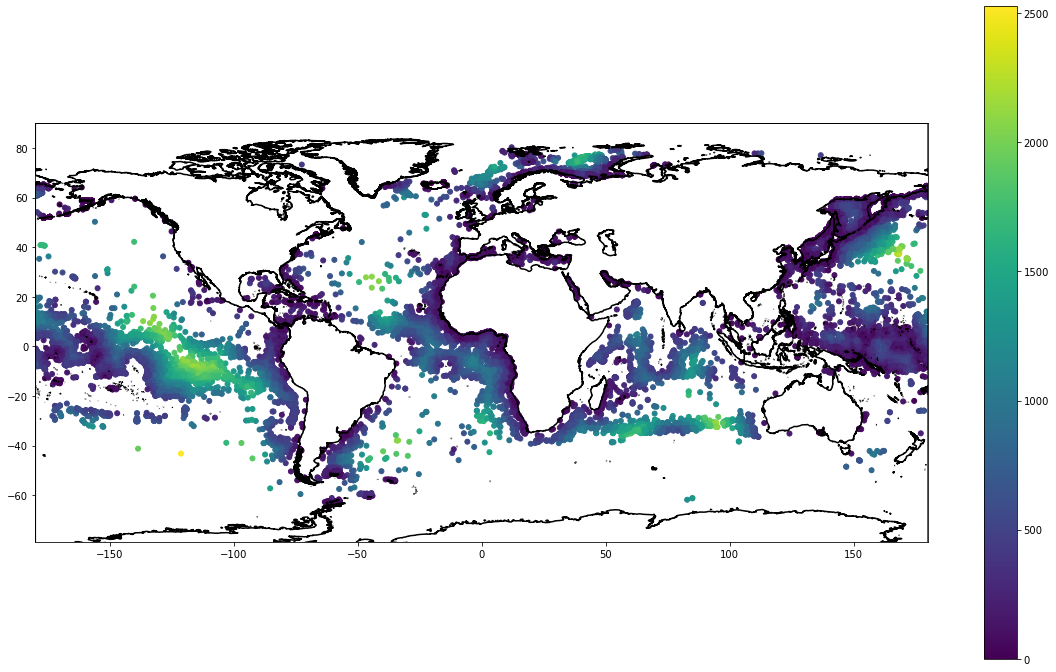

In [54]:
ax = ocean.boundary.plot(figsize=(20, 12), edgecolor = "black")#alternatively grey landmass: world.plot(figsize=(24, 18), color = 'grey', alpha = 0.4)

plotdf = geoplot.pointplot(gdf_clean_all, ax = ax, hue = 'distance_coast', legend = True)

plotdf.set_axis_on()

df_clean_all.info()

# Output
Now we are saving the dataset that we are going to use for clustering in the next step.

In [53]:
df_clean_all.to_csv('data/cleaned_data.csv', index=False)